In [14]:
#from /Users/hph/Dropbox/astrophys/juno/CMZoom_scripts import CMZoom_utility as cmz
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astrodendro
import os
from astropy import wcs
from astrodendro import Dendrogram, pp_catalog
from astrodendro.analysis import PPStatistic
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
import reproject
print(np.__version__)
#import aplpy
import csv
import pandas as pd
import CMZoom_utility as cmz
%config Completer.use_jedi = False
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important}</style>"))

%matplotlib notebook

1.21.2


/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_81155/96422386.py:20: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [15]:
##################################################################################################
### setup 
##################################################################################################
### picks for the accurate catalog
rms = 3.0e6
dend_min_v = 3
dend_min_d = 1
dend_min_pix = 17
prune_min_peak = 6
prune_min_mean = 2
path = '/Users/hph/Dropbox/astrophys/CMZoom/cmzoom_catalog/catalog_acc/'
savepath = '/Users/hph/Dropbox/astrophys/CMZoom/SF_tracer_paper/'
catalog = Table.read(path+'catalog_acc.fits')
writefile = '/Users/hph/Dropbox/astrophys/cmzoom_catalog/catalog_acc/megacatalog_acc_final_say.fits'
#######################################
### picks for the complete catalog
# rms = 3.0e6
# dend_min_v = 3
# dend_min_d = 1
# dend_min_pix = 17
# prune_min_peak = 4
# prune_min_mean = 2
# path = '/Users/hph/cmzoom_catalog/catalog_complete/'
# catalog = Table.read(path+'catalog_complete.fits')
# writefile = '/Users/hph/cmzoom_catalog/megacatalog_complete/catalog_complete.fits'
#######################################

date = '_02-02-20'
targetname = '_rms3e6_k14_dv'+str(dend_min_v)+'_dd'+str(dend_min_d)+'_dp'+str(dend_min_pix)+'_pp'+str(prune_min_peak)+'_pm'+str(prune_min_mean)+'_gal'+date

sma_path = path
herschel_path = path
catalog_path = path
figure_path = savepath

region_names = np.array(['G1.683-0.089', 
                      'G1.670-0.130', 
                      'G1.651-0.050', 
                      'G1.602+0.018',
                      'G1.085-0.027', 
                      'G1.038-0.074', 
                      'G0.891-0.048',
                      'G0.714-0.100',
                      'G0.699-0.028',
                      'G0.619+0.012',
                      'G0.489+0.010',
                      'G0.412+0.052',
                      'G0.393-0.034',
                      'G0.380+0.050',
                      'G0.340+0.055',
                      'G0.326-0.085',
                      'G0.316-0.201',
                      'G0.253+0.016',
                      'G0.212-0.001',
                      'G0.145-0.086',
                      'G0.106-0.082',
                      'G0.070-0.035',
                      'G0.068-0.075',
                      'G0.054+0.027',
                      'G0.014+0.021',
                      'G0.001-0.058',
                      'G359.948-0.052',
                      'G359.889-0.093',
                      'G359.865+0.022',
                      'G359.863-0.069',
                      'G359.734+0.002',
                      'G359.648-0.133',
                      'G359.611+0.018',
                      'G359.615-0.243',
                      'G359.484-0.132',
                      'G359.137+0.031'])

path = '/Users/hph/Dropbox/astrophys/CMZoom/cmzoom_catalog/catalog_acc/'
catalog = Table.read(path+'megacatalog_acc.fits')
teamcat = Table.read(path+'megacatalog_team_acc_final_say.fits')



In [16]:
###################################
### make columns for agreed tracers

### list of leaves to remove due to proximity to edge
ex_index = np.array([374,1067,3258,4005,20803,21252,21336,22434,22648,22947,23297])
### simultaneously remove sgrb2 and sgra*
goodmask = (1-np.isin(teamcat['index'],ex_index)) & (teamcat['mask_num']!=27) & (teamcat['mask_num']!=9)

#for keyi in ['8um_point_team','20-24um_point_team','70um_point_team','YSO_team','Walsh+2014_h2o_maser_team']

### new way, excluding edge indices
### define masking conditions for plotting
SF_all_cond = np.where(goodmask)[0]
SF_final_1cond = np.where((teamcat['SF_final_say']==1)&(goodmask))[0]
SF_final_2cond = np.where((teamcat['SF_final_say']==2)&(goodmask))[0]
SF_final_0cond = np.where((teamcat['SF_final_say']==0)&(goodmask))[0]
SF_final_1or2cond = np.where(((teamcat['SF_final_say']==1)|(teamcat['SF_final_say']==2))&(goodmask))[0]

SF_final_1cond_noncmz = np.where((teamcat['SF_final_say']==1)&(goodmask)
                                &((teamcat['mask_num']<8)|(teamcat['mask_num']==13)|(teamcat['mask_num']==17)|(teamcat['mask_num']==33)))[0]
SF_final_0cond_noncmz = np.where((teamcat['SF_final_say']==0)&(goodmask)
                                &((teamcat['mask_num']<8)|(teamcat['mask_num']==13)|(teamcat['mask_num']==17)|(teamcat['mask_num']==33)))[0]
SF_final_2cond_noncmz = np.where((teamcat['SF_final_say']==2)&(goodmask)
                                &((teamcat['mask_num']<8)|(teamcat['mask_num']==13)|(teamcat['mask_num']==17)|(teamcat['mask_num']==33)))[0]
SF_final_allcond_noncmz = np.where((goodmask)
                                &((teamcat['mask_num']<8)|(teamcat['mask_num']==13)|(teamcat['mask_num']==17)|(teamcat['mask_num']==33)))[0]

SF_final_1cond_cmz = np.where((teamcat['SF_final_say']==1)&(goodmask)
                                &((teamcat['mask_num']!=13) & (teamcat['mask_num']!=17) & (teamcat['mask_num']!=33)))[0]
SF_final_0cond_cmz = np.where((teamcat['SF_final_say']==0)&(goodmask)
                                &((teamcat['mask_num']!=13)&(teamcat['mask_num']!=17)&(teamcat['mask_num']!=33)))[0]
SF_final_2cond_cmz = np.where((teamcat['SF_final_say']==2)&(goodmask)
                                &((teamcat['mask_num']!=13)&(teamcat['mask_num']!=17)&(teamcat['mask_num']!=33)))[0]
SF_final_allcond_cmz = np.where((goodmask)
                                &((teamcat['mask_num']!=13)&(teamcat['mask_num']!=17)&(teamcat['mask_num']!=33)))[0]


In [17]:
print(f'The number of robustly star forming objects is: {len(SF_final_1cond)}')
print(f'The number of ambiguously star forming objects is: {len(SF_final_2cond)}')
print(f'The number of robustly non-star forming objects is: {len(SF_final_0cond)}')
print(38+57+104)

The number of robustly star forming objects is: 38
The number of ambiguously star forming objects is: 57
The number of robustly non-star forming objects is: 104
199


In [18]:
print(f'The number of robustly star forming objects in the CMZ is: {len(SF_final_1cond_cmz)}')
print(f'The number of ambiguously star forming objects in the CMZ is: {len(SF_final_2cond_cmz)}')
print(f'The number of robustly non-star forming objects in the CMZ is: {len(SF_final_0cond_cmz)}')

The number of robustly star forming objects in the CMZ is: 26
The number of ambiguously star forming objects in the CMZ is: 55
The number of robustly non-star forming objects in the CMZ is: 103


In [19]:
###################################################
### cloud by cloud sf properties
sfr_robust_bycloud = np.zeros(36)
sfr_any_bycloud = np.zeros(36)
dsfr_robust = np.zeros(36)
dsfrm_robust = np.zeros(36)
dsfr_any = np.zeros(36)
dsfr_eonly_robust = np.zeros(36)
dsfrm_eonly_robust = np.zeros(36)
dsfr_eonly_any = np.zeros(36)
sfr_robust_bycloud_plus = np.zeros(36)
sfr_robust_bycloud_minus = np.zeros(36)
sfr_any_bycloud_plus = np.zeros(36)
sfr_any_bycloud_minus = np.zeros(36)
cloud_mean_tff = np.zeros(36)
cloud_Nsf = np.zeros(36)
cloud_Fracsf = np.zeros(36)

dsfrp_robust_final = np.zeros(36)
dsfrm_robust_final = np.zeros(36)
dsfrp_robust_final_eonly = np.zeros(36)
dsfrm_robust_final_eonly = np.zeros(36)
### define cluster formation efficiency (from Ginsburg and Kruijssen 2018)
cfe=1.0+0.63 ## CFE in SgrB2 of 37+/-7%
sfe = 0.4 #0.1, 0.3, 0.5, .75 ## SFE used
dsfe= 0.3
dcfe = 0.07

for i in range(36):
    (teamcat['SF_final_say']==1)&(teamcat['mask_num']!=27) #& (teamcat['mask_num']!=9)
    ccond = np.where((teamcat['SF_final_say']==1)&(teamcat['mask_num']!=27) & 
                     (catalog['mask_num']==i+1))[0]  #& (teamcat['mask_num']!=9)
    cloud_Nsf[i]=len(ccond)
    if len(np.where(catalog['mask_num']==i+1)[0])!=0:
        cloud_Fracsf[i]=float(len(ccond))/float(len(np.where(catalog['mask_num']==i+1)[0]))
    canycond = np.where(((teamcat['SF_final_say']==1)|(teamcat['SF_final_say']==2))&(teamcat['mask_num']!=27) 
                        & (catalog['mask_num']==i+1))[0] #& (teamcat['mask_num']!=9)
    #sfr_robust_bycloud[i] = cfe*np.sum(sfe*catalog['mass'][ccond]/catalog['tff'][ccond]) ### old calculation?
    sfr_robust_bycloud[i] = (1./0.37)*np.sum(sfe*catalog['mass'][ccond]/catalog['tff'][ccond])
    sfr_any_bycloud[i] = cfe*np.sum(sfe*catalog['mass'][canycond]/catalog['tff'][canycond])
    cloud_mean_tff[i] = np.mean(catalog['tff'][ccond])
    
#     sfr_robust_bycloud_plus[i] = cfe*np.sum((sfe+0.3)*catalog['mass'][ccond]/catalog['tff'][ccond])
#     sfr_any_bycloud_plus[i] = cfe*np.sum((sfe+0.3)*catalog['mass'][canycond]/catalog['tff'][canycond])
#     sfr_robust_bycloud_minus[i] = cfe*np.sum((sfe-0.3)*catalog['mass'][ccond]/catalog['tff'][ccond])
#     sfr_any_bycloud_minus[i] = cfe*np.sum((sfe-0.3)*catalog['mass'][canycond]/catalog['tff'][canycond])

    
    dsfr_robust[i] = np.sqrt((cfe*dsfe*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2 + (dcfe*sfe*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2 + (cfe*sfe*2*np.sqrt(2)*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
    dsfr_any[i] = np.sqrt((cfe*dsfe*np.sum(catalog['mass'][canycond]/catalog['tff'][canycond]))**2 + (dcfe*sfe*np.sum(catalog['mass'][canycond]/catalog['tff'][canycond]))**2 + (cfe*sfe*2*np.sqrt(2)*np.sum(catalog['mass'][canycond]/catalog['tff'][canycond]))**2)
    dsfr_eonly_robust[i] = np.sqrt((cfe*dsfe*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2 + (dcfe*sfe*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
    dsfr_eonly_any[i] = np.sqrt((cfe*dsfe*np.sum(catalog['mass'][canycond]/catalog['tff'][canycond]))**2 + (dcfe*sfe*np.sum(catalog['mass'][canycond]/catalog['tff'][canycond]))**2)
    
    dsfrm_robust[i] = np.sqrt((cfe*dsfe*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2 + (dcfe*sfe*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2 + (cfe*sfe*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond])/(2*np.sqrt(2)))**2)
    dsfrm_eonly_robust[i] = np.sqrt((cfe*dsfe*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2 + (dcfe*sfe*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
    
    dsfrp_robust_final[i] = np.sqrt(((sfe/0.37)*np.sum(catalog['mass_unc'][ccond]/catalog['tff'][ccond]))**2 +
                                    ((sfe/0.37)*np.sum((catalog['mass'][ccond]*catalog['tff_unc'][ccond])/(catalog['tff'][ccond]**2)))**2 +
                                    ((dsfe/0.37)*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
    dsfrm_robust_final[i] = np.sqrt(((sfe)*np.sum(catalog['mass_unc'][ccond]/catalog['tff'][ccond]))**2 +
                                    ((sfe)*np.sum((catalog['mass'][ccond]*catalog['tff_unc'][ccond])/(catalog['tff'][ccond]**2)))**2 +
                                    ((dsfe)*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
    dsfrp_robust_final_eonly[i] = np.sqrt(((dsfe/0.37)*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
    dsfrm_robust_final_eonly[i] = np.sqrt(((dsfe)*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
    
cmz_sfr=0
for i in range(36):
    if (i+1!=9):
        #hdu1.data[mask_data==i+1] = sfr_robust_sfe30_bycloud[i]
        cmz_sfr+=sfr_robust_bycloud[i]
print(cmz_sfr)

0.24680838991655007


/Users/hph/anaconda3/envs/astrop3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/hph/anaconda3/envs/astrop3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [20]:
print(sfr_robust_bycloud)

[0.00000000e+00 2.94295257e-03 1.36690421e-03 3.66215519e-03
 5.88724432e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.03582402e+01 2.72749921e-02 1.44203272e-02 0.00000000e+00
 0.00000000e+00 3.45022969e-02 0.00000000e+00 0.00000000e+00
 2.76015834e-02 0.00000000e+00 4.58456479e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.00032088e-03 0.00000000e+00
 0.00000000e+00 3.61667029e-03 0.00000000e+00 2.93491874e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.63286258e-02 3.32705650e-02 0.00000000e+00 0.00000000e+00]


In [21]:
###################################################
### cloud by cloud sf properties
sfr_robust_upper = np.zeros(36)
sfr_robust_lower = np.zeros(36)
cloud_mean_tff = np.zeros(36)
cloud_Nsf = np.zeros(36)
cloud_Fracsf = np.zeros(36)
dsfr_robust_upper_plus = np.zeros(36)
dsfr_robust_upper_minus = np.zeros(36)
dsfr_robust_lower_plus = np.zeros(36)
dsfr_robust_lower_minus = np.zeros(36)

sgrb2_sfr = 0.035
sgrb2_sfr_max = 0.062

### define cluster formation efficiency (from Ginsburg and Kruijssen 2018)
cfe_high=1.0+0.63 ## CFE in SgrB2 of 37+/-7%
sfe = 0.4 #0.1, 0.3, 0.5, .75 ## SFE used
dsfe= 0.3
dcfe = 0.07

for i in range(36):
    ccond = np.where((teamcat['SF_final_say']==1)&(teamcat['mask_num']!=27) & 
                     (catalog['mask_num']==i+1) & (teamcat['mask_num']!=9) & 
                     (teamcat['mask_num']!=13) & (teamcat['mask_num']!=17) &
                     (teamcat['mask_num']!=33))[0]

    cloud_Nsf[i]=len(ccond)
    if len(np.where(catalog['mask_num']==i+1)[0])!=0:
        cloud_Fracsf[i]=float(len(ccond))/float(len(np.where(catalog['mask_num']==i+1)[0]))
    cloud_mean_tff[i] = np.mean(catalog['tff'][ccond])
    
    sfr_robust_bycloud[i] = (1./0.37)*np.sum(sfe*catalog['mass'][ccond]/catalog['tff'][ccond])

    sfr_robust_upper[i] = (sfe/0.37)*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond])
    sfr_robust_lower[i] = (sfe/1.0)*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond])
    
    dsfr_robust_upper_plus[i] = np.sqrt(((sfe/0.37)*np.sum(catalog['mass_unc'][ccond]/catalog['tff'][ccond]))**2 +
                                        ((sfe/0.37)*np.sum((catalog['mass'][ccond]*catalog['tff_unc'][ccond])/(catalog['tff'][ccond]**2)))**2 + 
                                        ((dsfe/0.37)*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
    dsfr_robust_upper_minus[i] = np.sqrt(((sfe/0.37)*np.sum(catalog['mass_unc'][ccond]/catalog['tff'][ccond]))**2 +
                                        ((sfe/0.37)*np.sum((catalog['mass'][ccond]*catalog['tff_unc'][ccond])/(catalog['tff'][ccond]**2)))**2 + 
                                        ((dsfe/0.37)*0.5*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
    dsfr_robust_lower_plus[i] = np.sqrt(((sfe/1.0)*np.sum(catalog['mass_unc'][ccond]/catalog['tff'][ccond]))**2 +
                                        ((sfe/1.0)*np.sum((catalog['mass'][ccond]*catalog['tff_unc'][ccond])/(catalog['tff'][ccond]**2)))**2 + 
                                        ((dsfe/1.0)*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
    dsfr_robust_lower_minus[i] = np.sqrt(((sfe/1.0)*np.sum(catalog['mass_unc'][ccond]/catalog['tff'][ccond]))**2 +
                                        ((sfe/1.0)*np.sum((catalog['mass'][ccond]*catalog['tff_unc'][ccond])/(catalog['tff'][ccond]**2)))**2 + 
                                        ((dsfe/1.0)*0.5*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)

cmz_sfr_upper=0.
cmz_sfr_lower=0.

for i in range(36):
    if (i+1!=9):
        cmz_sfr_upper+=sfr_robust_upper[i]
        cmz_sfr_lower+=sfr_robust_lower[i]
cmz_sfr_upper+=sgrb2_sfr_max
cmz_sfr_lower+=sgrb2_sfr
print(cmz_sfr_upper,cmz_sfr_lower)

0.2248781807932556 0.09526492689350458


In [9]:
cloud_Nsf

array([0., 2., 1., 1., 2., 0., 0., 0., 0., 7., 1., 0., 0., 1., 0., 0., 0.,
       0., 3., 0., 0., 0., 1., 0., 0., 5., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0.])

In [10]:
sfr_robust_upper

array([0.        , 0.00294295, 0.0013669 , 0.00366216, 0.00588724,
       0.        , 0.        , 0.        , 0.        , 0.02727499,
       0.01442033, 0.        , 0.        , 0.0345023 , 0.        ,
       0.        , 0.        , 0.        , 0.00458456, 0.        ,
       0.        , 0.        , 0.00200032, 0.        , 0.        ,
       0.00361667, 0.        , 0.02934919, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03327056, 0.        ,
       0.        ])

In [11]:
cloud_Nsf

array([0., 2., 1., 1., 2., 0., 0., 0., 0., 7., 1., 0., 0., 1., 0., 0., 0.,
       0., 3., 0., 0., 0., 1., 0., 0., 5., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0.])

In [12]:
cnames = np.array(['',
                 '',
                 '',
                 '',
                 '',
                 '',
                 '',
                 'The Chela Cloud',
                 'Sgr B2',
                 'Sgr B2 SE',
                 'Dust Ridge Clouds E\\&F',
                 'Dust Ridge Cloud D',
                 '',
                 'Dust Ridge Cloud C',
                 'Dust Ridge Cloud B',
                 'The Sailfish',
                 '',
                 'The Brick / The Lima Bean Cloud',
                 '',
                 'The Straw Cloud',
                 'The Sticks Cloud',
                 '',
                 'The Stone Cloud',
                 '',
                 '',
                 'The 20 km/s cloud',
                 'Sgr A*, circumnuclear disk',
                 'The 50 km/s cloud',
                 '',
                 '',
                 '',
                 '',
                 '',
                 'Sgr C',
                 '',
                 ''])

print(cnames)

['' '' '' '' '' '' '' 'The Chela Cloud' 'Sgr B2' 'Sgr B2 SE'
 'Dust Ridge Clouds E\\&F' 'Dust Ridge Cloud D' '' 'Dust Ridge Cloud C'
 'Dust Ridge Cloud B' 'The Sailfish' '' 'The Brick / The Lima Bean Cloud'
 '' 'The Straw Cloud' 'The Sticks Cloud' '' 'The Stone Cloud' '' ''
 'The 20 km/s cloud' 'Sgr A*, circumnuclear disk' 'The 50 km/s cloud' ''
 '' '' '' '' 'Sgr C' '' '']


In [14]:

# ###################################################
# ### make LaTeX table
# ###################################################

# print('\\begin{tabular}{llllllll}')
# print('\hline\hline')
# print(' Cloud ID & Colloquial Name & \\textit{CMZoom} & SFR$_{0.4}$ & $\Delta$SFR$_{0.4}$ & $\Delta$SFR$_{\\rm 0.4, \epsilon only}$ & N$_{\\rm SF}$ & N$_{\\rm SF}$/N$_{\\rm tot}$ \\\\')
# print(' & & mask number & & & & \\\\')              
# print('\hline')

# for ic, cloud in enumerate(region_names):
#     if sfr_robust_bycloud[ic]==0:
#         print('%i & %s & %s & n/a & n/a & n/a & %i & n/a \\\\' %\
#              (ic+1, cloud, cnames[ic],cloud_Nsf[ic]))
#     else:
#         print('%i & %s & %s & %1.3f & %1.3f & %1.3f & %i & %1.3f \\\\' %\
#              (ic+1,cloud, cnames[ic],sfr_robust_bycloud[ic],dsfr_robust[ic],dsfr_eonly_robust[ic],cloud_Nsf[ic],cloud_Fracsf[ic]))

# print('\hline\hline')
# print('\end{tabular}')
# print(' ')
# print(' ')  


In [15]:

###################################################
### make LaTeX table
###################################################

print('\\begin{tabular}{lllllll}')
print('\hline\hline')
print(' Cloud ID & Colloquial Name & \\textit{CMZoom} & SFR$_{\\rm upper}$ & SFR$_{\\rm lower}$ & N$_{\\rm SF}$ & N$_{\\rm SF}$/N$_{\\rm tot}$ \\\\')
print(' & & mask number & & & \\\\')              
print('\hline')

for ic, cloud in enumerate(region_names):
    if sfr_robust_bycloud[ic]==0:
        print('%i & %s & %s & -- & -- & %i & -- \\\\' %\
             (ic+1, cloud, cnames[ic],cloud_Nsf[ic]))
    else:
        print('%i & %s & %s & %1.3f & %1.3f & %i & %1.3f \\\\' %\
             (ic+1,cloud, cnames[ic],sfr_robust_upper[ic],sfr_robust_lower[ic],cloud_Nsf[ic],cloud_Fracsf[ic]))

print('\hline\hline')
print('\end{tabular}')
print(' ')
print(' ')  


\begin{tabular}{lllllll}
\hline\hline
 Cloud ID & Colloquial Name & \textit{CMZoom} & SFR$_{\rm upper}$ & SFR$_{\rm lower}$ & N$_{\rm SF}$ & N$_{\rm SF}$/N$_{\rm tot}$ \\
 & & mask number & & & \\
\hline
1 & G1.683-0.089 &  & -- & -- & 0 & -- \\
2 & G1.670-0.130 &  & 0.003 & 0.001 & 2 & 0.333 \\
3 & G1.651-0.050 &  & 0.001 & 0.001 & 1 & 0.500 \\
4 & G1.602+0.018 &  & 0.004 & 0.001 & 1 & 0.200 \\
5 & G1.085-0.027 &  & 0.006 & 0.002 & 2 & 0.667 \\
6 & G1.038-0.074 &  & -- & -- & 0 & -- \\
7 & G0.891-0.048 &  & -- & -- & 0 & -- \\
8 & G0.714-0.100 & The Chela Cloud & -- & -- & 0 & -- \\
9 & G0.699-0.028 & Sgr B2 & -- & -- & 0 & -- \\
10 & G0.619+0.012 & Sgr B2 SE & 0.027 & 0.010 & 7 & 0.700 \\
11 & G0.489+0.010 & Dust Ridge Clouds E\&F & 0.014 & 0.005 & 1 & 0.077 \\
12 & G0.412+0.052 & Dust Ridge Cloud D & -- & -- & 0 & -- \\
13 & G0.393-0.034 &  & -- & -- & 0 & -- \\
14 & G0.380+0.050 & Dust Ridge Cloud C & 0.035 & 0.013 & 1 & 0.125 \\
15 & G0.340+0.055 & Dust Ridge Cloud B & -- & -- & 0

In [16]:
print(f'The number of clouds with SF tracers is {sum(sfr_robust_bycloud!=0)}')

The number of clouds with SF tracers is 12


In [17]:
print(np.sqrt(np.sum((dsfr_robust[dsfr_robust<1.0])**2)))

0.159258703852997


In [18]:
%matplotlib notebook

/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_49454/2217075279.py:2: RuntimeWarning: divide by zero encountered in log10
  sfr_centers = 10**((np.log10(sfr_robust_upper)-np.log10(sfr_robust_lower))/2)
/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_49454/2217075279.py:2: RuntimeWarning: invalid value encountered in subtract
  sfr_centers = 10**((np.log10(sfr_robust_upper)-np.log10(sfr_robust_lower))/2)


<IPython.core.display.Javascript object>


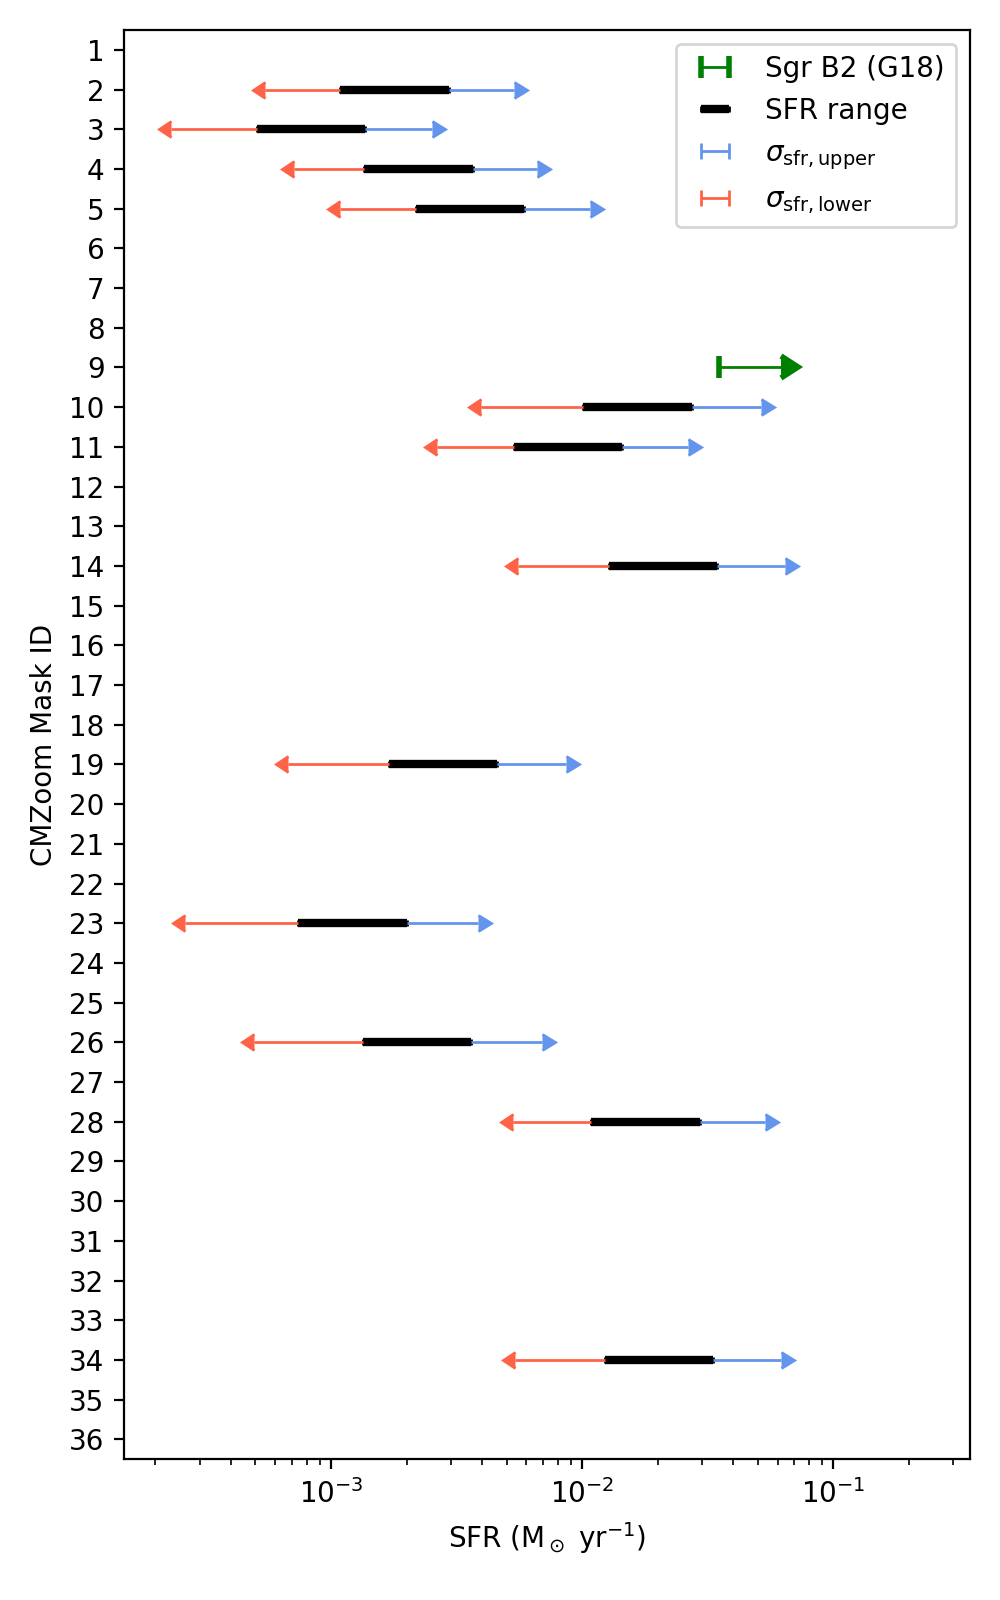

In [19]:
### plot sfr by cloud with errors (bounds with uncertainties, 8/22)
sfr_centers = 10**((np.log10(sfr_robust_upper)-np.log10(sfr_robust_lower))/2)

fig, ax = plt.subplots(figsize=(5,8))
ax.set_ylim(36.5,0.5)
ax.set_xlim(0.00015,0.35)
ax.errorbar(x=[0.035],y=[9], xlolims=True, xerr=0.062-0.035,color='green',capsize=4,
           capthick=2.0,ls='',linewidth=1.0,label='Sgr B2 (G18)')
ax.errorbar(y=np.arange(1,37),x=sfr_centers, xerr=(sfr_centers-sfr_robust_lower,sfr_robust_upper-sfr_centers),
            ls='',linewidth=3,marker='',color='k',capsize=1,
            label='SFR range')
ax.errorbar(y=np.arange(1,37),x=sfr_robust_upper, xerr=dsfr_robust_upper_plus,
             ls='',linewidth=1.0,marker='',color='cornflowerblue',capsize=0,zorder=100, 
             xlolims=True,label='$\sigma_{\\rm sfr, upper}$')
ax.errorbar(y=np.arange(1,37),x=sfr_robust_lower, xerr=dsfr_robust_lower_minus,
             ls='',linewidth=1.0,marker='',color='tomato',capsize=0,zorder=100, 
             xuplims=True,label='$\sigma_{\\rm sfr, lower}$')
ax.set_yticks(np.arange(1,37))
ax.set_xscale('log')
ax.set_xlabel('SFR (M$_\odot$ yr$^{-1}$)')
ax.set_ylabel('CMZoom Mask ID')
ax.legend(loc='upper right')
fig.tight_layout()

/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_49454/1594527811.py:2: RuntimeWarning: divide by zero encountered in log10
  sfr_centers = 10**((np.log10(sfr_robust_upper)-np.log10(sfr_robust_lower))/2)
/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_49454/1594527811.py:2: RuntimeWarning: invalid value encountered in subtract
  sfr_centers = 10**((np.log10(sfr_robust_upper)-np.log10(sfr_robust_lower))/2)


<IPython.core.display.Javascript object>


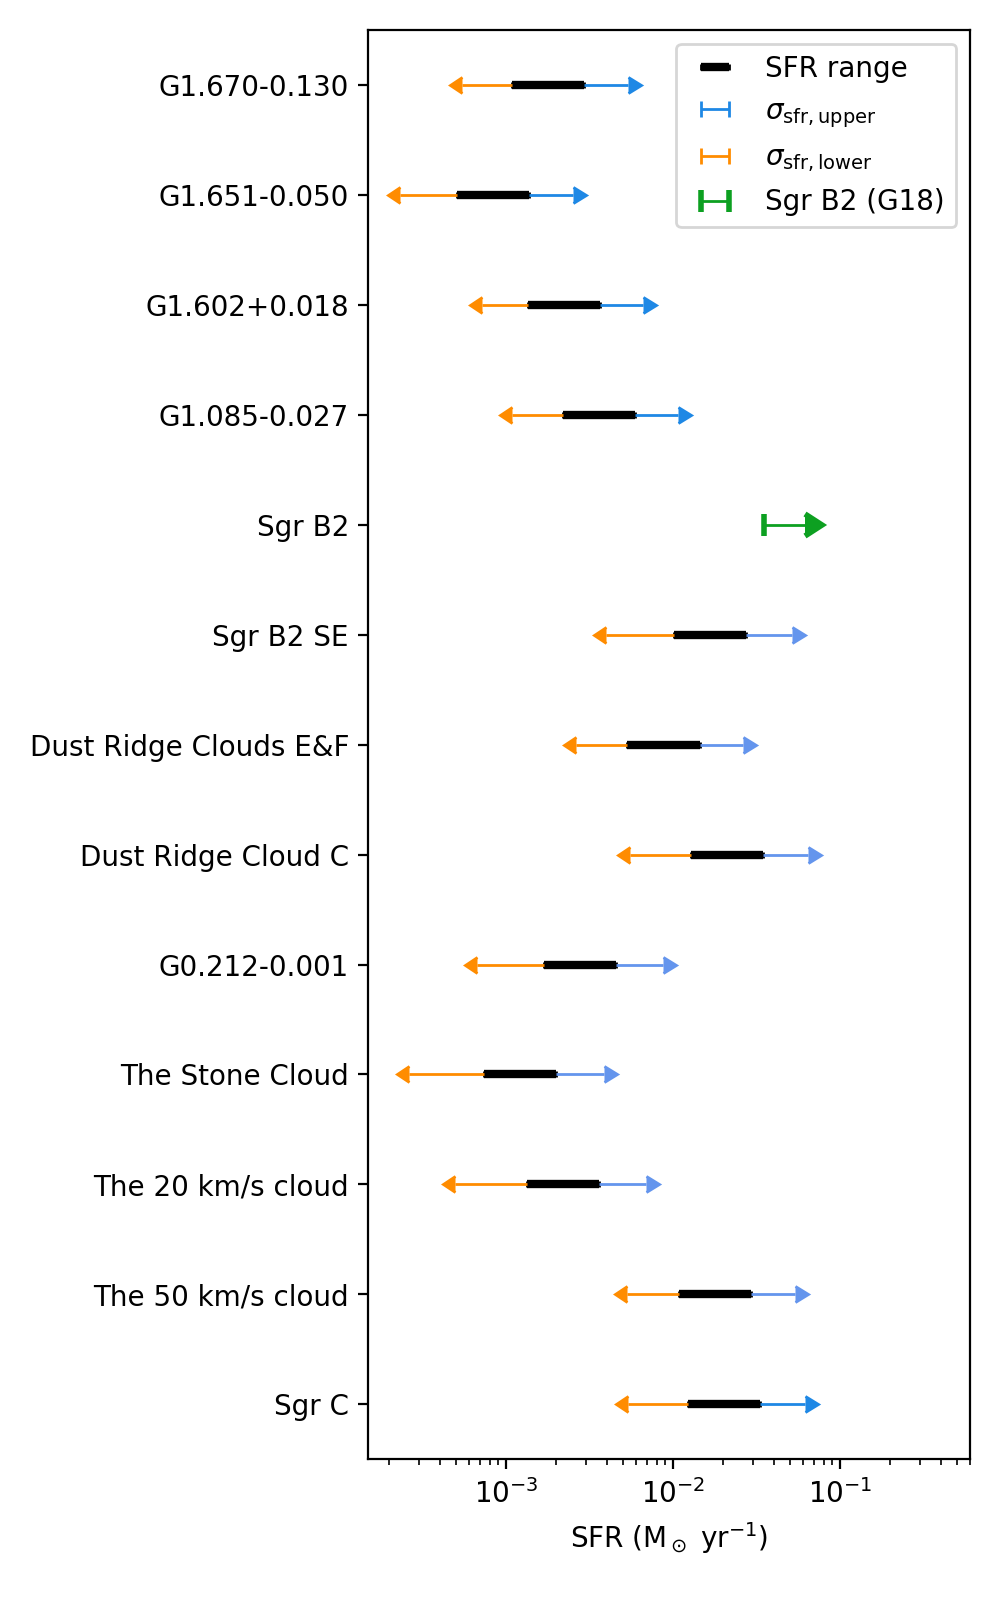

In [20]:
### plot sfr by cloud with errors (bounds with uncertainties, 8/22)
sfr_centers = 10**((np.log10(sfr_robust_upper)-np.log10(sfr_robust_lower))/2)
sfr_cnames = ['G1.670-0.130', 'G1.651-0.050', 'G1.602+0.018', 'G1.085-0.027', 'Sgr B2', 'Sgr B2 SE', 'Dust Ridge Clouds E&F', 'Dust Ridge Cloud C', 'G0.212-0.001',
 'The Stone Cloud', 'The 20 km/s cloud', 'The 50 km/s cloud', 'Sgr C']

sfrcond = np.where(sfr_robust_lower>0)[0]
sub_sfr_robust_lower = sfr_robust_lower[sfrcond]
sub_sfr_robust_upper = sfr_robust_upper[sfrcond]
sub_dsfr_robust_upper_plus = dsfr_robust_upper_plus[sfrcond]
sub_dsfr_robust_lower_minus = dsfr_robust_lower_minus[sfrcond]
sub_sfr_centers = sfr_centers[sfrcond]

fig, ax = plt.subplots(figsize=(5,8))
ax.set_ylim(12.5,-0.5)
ax.set_xlim(0.00015,0.6)
# ax.errorbar(x=[0.035],y=[9], xlolims=True, xerr=0.062-0.035,color='green',capsize=4,
#            capthick=2.0,ls='',linewidth=1.0,label='Sgr B2 (G18)')
for i in range(len(sub_sfr_centers+1)):
    if i<4:
        ax.errorbar(y=i,x=sub_sfr_centers[i], xerr=([sub_sfr_centers[i]-sub_sfr_robust_lower[i]], [sub_sfr_robust_upper[i]-sub_sfr_centers[i]]),
                    ls='',linewidth=3,marker='',color='k',capsize=1)
        ax.errorbar(y=i,x=sub_sfr_robust_upper[i], xerr=sub_dsfr_robust_upper_plus[i],
                     ls='',linewidth=1.0,marker='',color='#1E88E5',capsize=0,zorder=100, 
                     xlolims=True)
        ax.errorbar(y=i,x=sub_sfr_robust_lower[i], xerr=sub_dsfr_robust_lower_minus[i],
                     ls='',linewidth=1.0,marker='',color='darkorange',capsize=0,zorder=100, 
                     xuplims=True)
    elif i==len(sub_sfr_centers)-1:
        ax.errorbar(y=i+1,x=sub_sfr_centers[i], xerr=([sub_sfr_centers[i]-sub_sfr_robust_lower[i]], [sub_sfr_robust_upper[i]-sub_sfr_centers[i]]),
                    ls='',linewidth=3,marker='',color='k',capsize=1,label='SFR range')
        ax.errorbar(y=i+1,x=sub_sfr_robust_upper[i], xerr=sub_dsfr_robust_upper_plus[i],
                     ls='',linewidth=1.0,marker='',color='#1E88E5',capsize=0,zorder=100, 
                     xlolims=True,label='$\sigma_{\\rm sfr, upper}$')
        ax.errorbar(y=i+1,x=sub_sfr_robust_lower[i], xerr=sub_dsfr_robust_lower_minus[i],
                     ls='',linewidth=1.0,marker='',color='darkorange',capsize=0,zorder=100, 
                     xuplims=True,label='$\sigma_{\\rm sfr, lower}$')
    else:
        ax.errorbar(y=i+1,x=sub_sfr_centers[i], xerr=([sub_sfr_centers[i]-sub_sfr_robust_lower[i]], [sub_sfr_robust_upper[i]-sub_sfr_centers[i]]),
                    ls='',linewidth=3,marker='',color='k',capsize=1)
        ax.errorbar(y=i+1,x=sub_sfr_robust_upper[i], xerr=sub_dsfr_robust_upper_plus[i],
                     ls='',linewidth=1.0,marker='',color='cornflowerblue',capsize=0,zorder=100, 
                     xlolims=True)
        ax.errorbar(y=i+1,x=sub_sfr_robust_lower[i], xerr=sub_dsfr_robust_lower_minus[i],
                     ls='',linewidth=1.0,marker='',color='darkorange',capsize=0,zorder=100, 
                     xuplims=True)

ax.errorbar(x=[0.035],y=[4], xlolims=True, xerr=0.062-0.035,color='#0DA021',capsize=4,
                    capthick=2.0,ls='',linewidth=1.0,label='Sgr B2 (G18)')

ax.set_yticks(np.arange(0,13))
ax.set_yticklabels(sfr_cnames)
ax.set_xscale('log')
ax.set_xlabel('SFR (M$_\odot$ yr$^{-1}$)')
#ax.set_ylabel('CMZoom Mask ID')
ax.legend(loc='upper right')
fig.tight_layout()


/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_81155/1594527811.py:2: RuntimeWarning: divide by zero encountered in log10
  sfr_centers = 10**((np.log10(sfr_robust_upper)-np.log10(sfr_robust_lower))/2)
/var/folders/5j/kk60b8j15ljg_0ddrg10l6100000gn/T/ipykernel_81155/1594527811.py:2: RuntimeWarning: invalid value encountered in subtract
  sfr_centers = 10**((np.log10(sfr_robust_upper)-np.log10(sfr_robust_lower))/2)


<IPython.core.display.Javascript object>


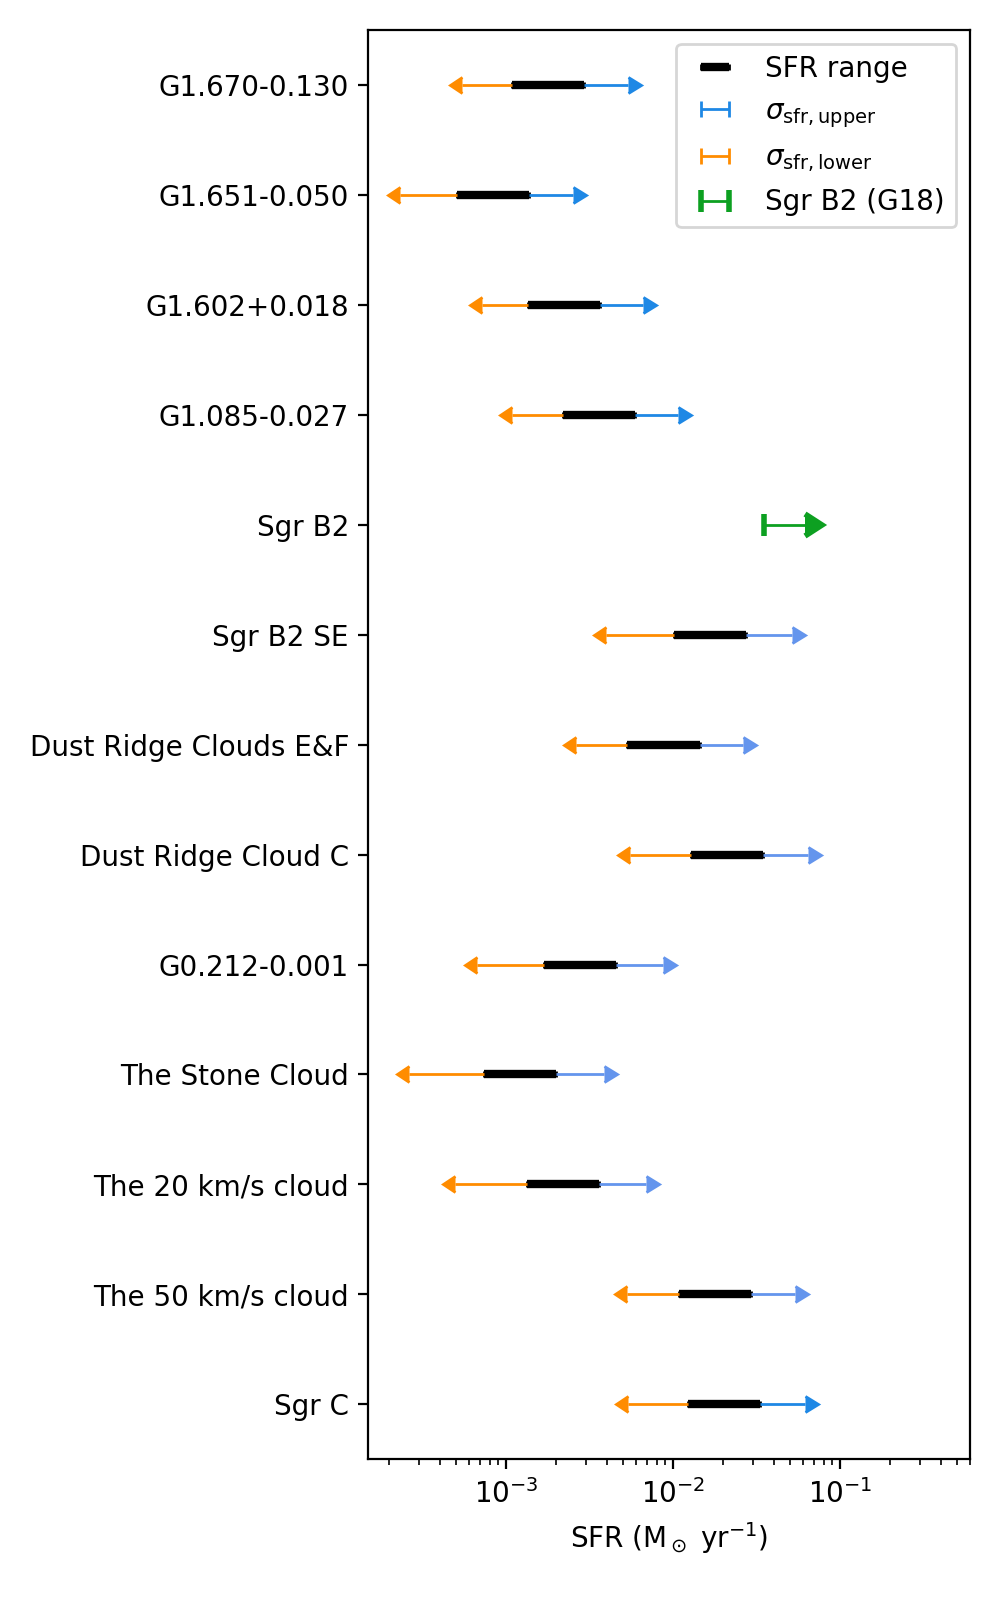

In [23]:
### plot sfr by cloud with errors (bounds with uncertainties, 8/22)
sfr_centers = 10**((np.log10(sfr_robust_upper)-np.log10(sfr_robust_lower))/2)
sfr_cnames = ['G1.670-0.130', 'G1.651-0.050', 'G1.602+0.018', 'G1.085-0.027', 'Sgr B2', 'Sgr B2 SE', 'Dust Ridge Clouds E&F', 'Dust Ridge Cloud C', 'G0.212-0.001',
 'The Stone Cloud', 'The 20 km/s cloud', 'The 50 km/s cloud', 'Sgr C']

sfrcond = np.where(sfr_robust_lower>0)[0]
sub_sfr_robust_lower = sfr_robust_lower[sfrcond]
sub_sfr_robust_upper = sfr_robust_upper[sfrcond]
sub_dsfr_robust_upper_plus = dsfr_robust_upper_plus[sfrcond]
sub_dsfr_robust_lower_minus = dsfr_robust_lower_minus[sfrcond]
sub_sfr_centers = sfr_centers[sfrcond]

fig, ax = plt.subplots(figsize=(5,8))
ax.set_ylim(12.5,-0.5)
ax.set_xlim(0.00015,0.6)
# ax.errorbar(x=[0.035],y=[9], xlolims=True, xerr=0.062-0.035,color='green',capsize=4,
#            capthick=2.0,ls='',linewidth=1.0,label='Sgr B2 (G18)')
for i in range(len(sub_sfr_centers+1)):
    if i<4:
        ax.errorbar(y=i,x=sub_sfr_centers[i], xerr=([sub_sfr_centers[i]-sub_sfr_robust_lower[i]], [sub_sfr_robust_upper[i]-sub_sfr_centers[i]]),
                    ls='',linewidth=3,marker='',color='k',capsize=1)
        ax.errorbar(y=i,x=sub_sfr_robust_upper[i], xerr=sub_dsfr_robust_upper_plus[i],
                     ls='',linewidth=1.0,marker='',color='#1E88E5',capsize=0,zorder=100, 
                     xlolims=True)
        ax.errorbar(y=i,x=sub_sfr_robust_lower[i], xerr=sub_dsfr_robust_lower_minus[i],
                     ls='',linewidth=1.0,marker='',color='darkorange',capsize=0,zorder=100, 
                     xuplims=True)
    elif i==len(sub_sfr_centers)-1:
        ax.errorbar(y=i+1,x=sub_sfr_centers[i], xerr=([sub_sfr_centers[i]-sub_sfr_robust_lower[i]], [sub_sfr_robust_upper[i]-sub_sfr_centers[i]]),
                    ls='',linewidth=3,marker='',color='k',capsize=1,label='SFR range')
        ax.errorbar(y=i+1,x=sub_sfr_robust_upper[i], xerr=sub_dsfr_robust_upper_plus[i],
                     ls='',linewidth=1.0,marker='',color='#1E88E5',capsize=0,zorder=100, 
                     xlolims=True,label='$\sigma_{\\rm sfr, upper}$')
        ax.errorbar(y=i+1,x=sub_sfr_robust_lower[i], xerr=sub_dsfr_robust_lower_minus[i],
                     ls='',linewidth=1.0,marker='',color='darkorange',capsize=0,zorder=100, 
                     xuplims=True,label='$\sigma_{\\rm sfr, lower}$')
    else:
        ax.errorbar(y=i+1,x=sub_sfr_centers[i], xerr=([sub_sfr_centers[i]-sub_sfr_robust_lower[i]], [sub_sfr_robust_upper[i]-sub_sfr_centers[i]]),
                    ls='',linewidth=3,marker='',color='k',capsize=1)
        ax.errorbar(y=i+1,x=sub_sfr_robust_upper[i], xerr=sub_dsfr_robust_upper_plus[i],
                     ls='',linewidth=1.0,marker='',color='cornflowerblue',capsize=0,zorder=100, 
                     xlolims=True)
        ax.errorbar(y=i+1,x=sub_sfr_robust_lower[i], xerr=sub_dsfr_robust_lower_minus[i],
                     ls='',linewidth=1.0,marker='',color='darkorange',capsize=0,zorder=100, 
                     xuplims=True)

ax.errorbar(x=[0.035],y=[4], xlolims=True, xerr=0.062-0.035,color='#0DA021',capsize=4,
                    capthick=2.0,ls='',linewidth=1.0,label='Sgr B2 (G18)')

ax.set_yticks(np.arange(0,13))
ax.set_yticklabels(sfr_cnames)
ax.set_xscale('log')
ax.set_xlabel('SFR (M$_\odot$ yr$^{-1}$)')
#ax.set_ylabel('CMZoom Mask ID')
ax.legend(loc='upper right')
fig.tight_layout()


In [24]:
###########################

In [36]:
### cloud bound analysis, but with varying temperature
### calculate 50K masses, tffs

### calculate SFRs and uncertainties
sfr_robust_Td_h = np.zeros(36)
sfr_robust_Td_m = np.zeros(36)
sfr_robust_Td_l = np.zeros(36)
# cloud_mean_tff = np.zeros(36)
# cloud_Nsf = np.zeros(36)
# cloud_Fracsf = np.zeros(36)
# dsfr_robust_upper_plus = np.zeros(36)
# dsfr_robust_upper_minus = np.zeros(36)
# dsfr_robust_lower_plus = np.zeros(36)
# dsfr_robust_lower_minus = np.zeros(36)

sgrb2_sfr = 0.035
sgrb2_sfr_max = 0.062

sfe = 0.2
dsfe= 0.1
Td_l = 20
Td_m = 50
Td_h = 100

### calculate upper masses
mass_Td_l = teamcat['mass']
mass_Td_m = cmz.mass_calc_submm(cmz.Wave, Td_m, cmz.Kappa, teamcat['flux_integrated'], cmz.distance)
mass_Td_h = cmz.mass_calc_submm(cmz.Wave, Td_h, cmz.Kappa, teamcat['flux_integrated'], cmz.distance)

tff_Td_l = teamcat['tff']
tff_Td_m = cmz.tff_spherical_F(cmz.number_density_sphere_pc(mass_Td_m, catalog['r_eff'].data*cmz.arcsec2pc, cmz.mu), cmz.mu)
tff_Td_h = cmz.tff_spherical_F(cmz.number_density_sphere_pc(mass_Td_h, catalog['r_eff'].data*cmz.arcsec2pc, cmz.mu), cmz.mu)

for i in range(36):
    ccond = np.where((teamcat['SF_final_say']==1)&(teamcat['mask_num']!=27) & 
                     (catalog['mask_num']==i+1) & (teamcat['mask_num']!=9) & 
                     (teamcat['mask_num']!=13) & (teamcat['mask_num']!=17) &
                     (teamcat['mask_num']!=33))[0]

    sfr_robust_Td_l[i] = sfe*np.sum(mass_Td_l[ccond]/tff_Td_l[ccond])
    sfr_robust_Td_m[i] = sfe*np.sum(mass_Td_m[ccond]/tff_Td_m[ccond])
    sfr_robust_Td_h[i] = sfe*np.sum(mass_Td_h[ccond]/tff_Td_h[ccond])
    
#     dsfr_robust_upper_plus[i] = np.sqrt((sfe*np.sum(catalog['mass_unc'][ccond]/catalog['tff'][ccond]))**2 +
#                                         (sfe*np.sum((catalog['mass'][ccond]*catalog['tff_unc'][ccond])/(catalog['tff'][ccond]**2)))**2 + 
#                                         (dsfe*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
#     dsfr_robust_upper_minus[i] = np.sqrt(((sfe/0.37)*np.sum(catalog['mass_unc'][ccond]/catalog['tff'][ccond]))**2 +
#                                         ((sfe/0.37)*np.sum((catalog['mass'][ccond]*catalog['tff_unc'][ccond])/(catalog['tff'][ccond]**2)))**2 + 
#                                         ((dsfe/0.37)*0.5*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
#     dsfr_robust_lower_plus[i] = np.sqrt(((sfe/1.0)*np.sum(catalog['mass_unc'][ccond]/catalog['tff'][ccond]))**2 +
#                                         ((sfe/1.0)*np.sum((catalog['mass'][ccond]*catalog['tff_unc'][ccond])/(catalog['tff'][ccond]**2)))**2 + 
#                                         ((dsfe/1.0)*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
#     dsfr_robust_lower_minus[i] = np.sqrt(((sfe/1.0)*np.sum(catalog['mass_unc'][ccond]/catalog['tff'][ccond]))**2 +
#                                         ((sfe/1.0)*np.sum((catalog['mass'][ccond]*catalog['tff_unc'][ccond])/(catalog['tff'][ccond]**2)))**2 + 
#                                         ((dsfe/1.0)*0.5*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)

cmz_sfr_Td_h = 0.
cmz_sfr_Td_m = 0.
cmz_sfr_Td_l = 0.

for i in range(36):
    if (i+1!=9):
        cmz_sfr_Td_h+=sfr_robust_Td_h[i]
        cmz_sfr_Td_m+=sfr_robust_Td_m[i]
        cmz_sfr_Td_l+=sfr_robust_Td_l[i]
cmz_sfr_Td_l+=sgrb2_sfr
cmz_sfr_Td_m+=sgrb2_sfr
cmz_sfr_Td_h+=sgrb2_sfr

print(cmz_sfr_Td_h, cmz_sfr_Td_m, cmz_sfr_Td_l)


0.03722063786638439 0.04182803345704355 0.06513246344675229


In [38]:
### cloud bound analysis, but with varying temperature FOR ALL SF (including ambiguous) and implied sfr by IMF
### makes the assumption that detected sources are high mass component of IMF ONLY (low mass elsewhere undetected)

### calculate IMF extrapolation 
import imf
kroupa = imf.Kroupa()
mmax = 200
cutoff1 = 8
over8fraction = (kroupa.m_integrate(cutoff1, mmax)[0] /
                 kroupa.m_integrate(kroupa.mmin, mmax)[0])
over8fraction = 1.

### calculate 50K, 100K masses, tffs
sfr_robust_Td_h = np.zeros(36)
sfr_robust_Td_m = np.zeros(36)
sfr_robust_Td_l = np.zeros(36)

sgrb2_sfr = 0.035
sgrb2_sfr_max = 0.062

sfe = 0.1
dsfe= 0.1
Td_l = 20
Td_m = 50
Td_h = 100

### calculate upper masses
mass_Td_l = teamcat['mass']
mass_Td_m = cmz.mass_calc_submm(cmz.Wave, Td_m, cmz.Kappa, teamcat['flux_integrated'], cmz.distance)
mass_Td_h = cmz.mass_calc_submm(cmz.Wave, Td_h, cmz.Kappa, teamcat['flux_integrated'], cmz.distance)

tff_Td_l = teamcat['tff']
tff_Td_m = cmz.tff_spherical_F(cmz.number_density_sphere_pc(mass_Td_m, catalog['r_eff'].data*cmz.arcsec2pc, cmz.mu), cmz.mu)
tff_Td_h = cmz.tff_spherical_F(cmz.number_density_sphere_pc(mass_Td_h, catalog['r_eff'].data*cmz.arcsec2pc, cmz.mu), cmz.mu)

for i in range(36):
    ccond = np.where(((teamcat['SF_final_say']==1)|(teamcat['SF_final_say']==2))&(teamcat['mask_num']!=27) & 
                     (catalog['mask_num']==i+1) & (teamcat['mask_num']!=9) & 
                     (teamcat['mask_num']!=13) & (teamcat['mask_num']!=17) &
                     (teamcat['mask_num']!=33))[0]

    sfr_robust_Td_l[i] = sfe*np.sum(mass_Td_l[ccond]/tff_Td_l[ccond])/over8fraction
    sfr_robust_Td_m[i] = sfe*np.sum(mass_Td_m[ccond]/tff_Td_m[ccond])/over8fraction
    sfr_robust_Td_h[i] = sfe*np.sum(mass_Td_h[ccond]/tff_Td_h[ccond])/over8fraction
    
#     dsfr_robust_upper_plus[i] = np.sqrt((sfe*np.sum(catalog['mass_unc'][ccond]/catalog['tff'][ccond]))**2 +
#                                         (sfe*np.sum((catalog['mass'][ccond]*catalog['tff_unc'][ccond])/(catalog['tff'][ccond]**2)))**2 + 
#                                         (dsfe*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
#     dsfr_robust_upper_minus[i] = np.sqrt(((sfe/0.37)*np.sum(catalog['mass_unc'][ccond]/catalog['tff'][ccond]))**2 +
#                                         ((sfe/0.37)*np.sum((catalog['mass'][ccond]*catalog['tff_unc'][ccond])/(catalog['tff'][ccond]**2)))**2 + 
#                                         ((dsfe/0.37)*0.5*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
#     dsfr_robust_lower_plus[i] = np.sqrt(((sfe/1.0)*np.sum(catalog['mass_unc'][ccond]/catalog['tff'][ccond]))**2 +
#                                         ((sfe/1.0)*np.sum((catalog['mass'][ccond]*catalog['tff_unc'][ccond])/(catalog['tff'][ccond]**2)))**2 + 
#                                         ((dsfe/1.0)*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)
#     dsfr_robust_lower_minus[i] = np.sqrt(((sfe/1.0)*np.sum(catalog['mass_unc'][ccond]/catalog['tff'][ccond]))**2 +
#                                         ((sfe/1.0)*np.sum((catalog['mass'][ccond]*catalog['tff_unc'][ccond])/(catalog['tff'][ccond]**2)))**2 + 
#                                         ((dsfe/1.0)*0.5*np.sum(catalog['mass'][ccond]/catalog['tff'][ccond]))**2)

cmz_sfr_Td_h = 0.
cmz_sfr_Td_m = 0.
cmz_sfr_Td_l = 0.

for i in range(36):
    if (i+1!=9):
        cmz_sfr_Td_h+=sfr_robust_Td_h[i]
        cmz_sfr_Td_m+=sfr_robust_Td_m[i]
        cmz_sfr_Td_l+=sfr_robust_Td_l[i]
# cmz_sfr_Td_l+=sgrb2_sfr
# cmz_sfr_Td_m+=sgrb2_sfr
# cmz_sfr_Td_h+=sgrb2_sfr
cmz_sfr_Td_l = cmz_sfr_Td_l + sgrb2_sfr
cmz_sfr_Td_m = cmz_sfr_Td_m + sgrb2_sfr
cmz_sfr_Td_h = cmz_sfr_Td_h + sgrb2_sfr

print(cmz_sfr_Td_h, cmz_sfr_Td_m, cmz_sfr_Td_l)


0.03639298322061528 0.0392831549346439 0.05447803815245181


<IPython.core.display.Javascript object>


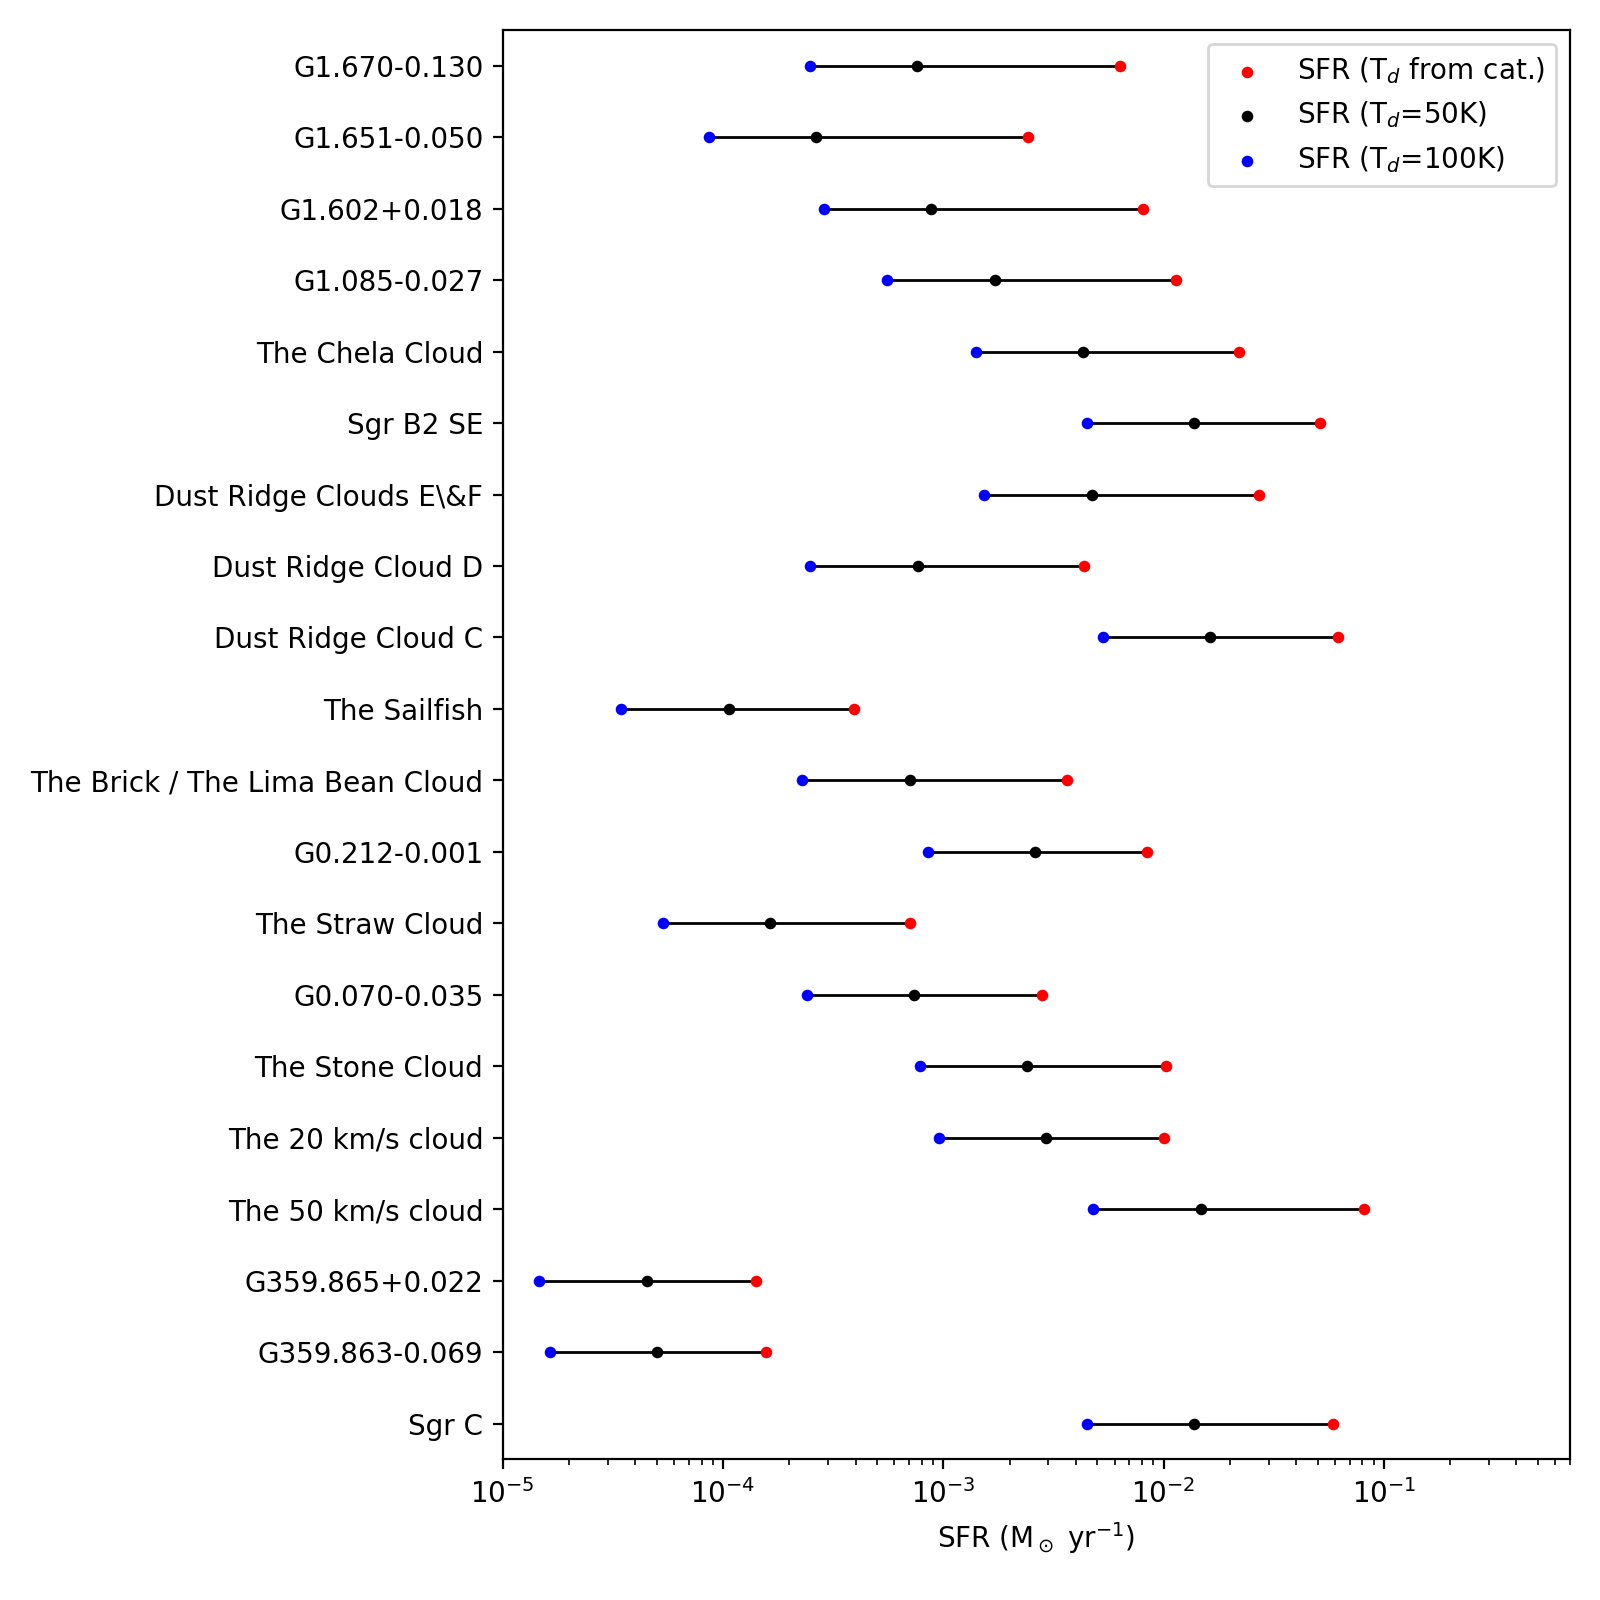

In [27]:
### plot sfr by cloud for verying temperature
sfr_cnames_nsgrb2 = ['G1.670-0.130', 'G1.651-0.050', 'G1.602+0.018', 'G1.085-0.027', 'Sgr B2 SE', 'Dust Ridge Clouds E&F', 'Dust Ridge Cloud C', 'G0.212-0.001',
 'The Stone Cloud', 'The 20 km/s cloud', 'The 50 km/s cloud', 'Sgr C']

sfrcond = np.where(sfr_robust_Td_h>0)[0]
sub_sfr_robust_lower = sfr_robust_Td_h[sfrcond]
sub_sfr_centers = sfr_robust_Td_m[sfrcond]
sub_sfr_robust_upper = sfr_robust_Td_l[sfrcond]

fig, ax = plt.subplots(figsize=(8,8))
ax.set_ylim(19.5,-0.5)
ax.set_xlim(0.00001,0.7)
# ax.errorbar(x=[0.035],y=[9], xlolims=True, xerr=0.062-0.035,color='green',capsize=4,
#            capthick=2.0,ls='',linewidth=1.0,label='Sgr B2 (G18)')
for i in range(len(sub_sfr_centers)):
    if i==len(sub_sfr_centers)-1:
        ax.scatter(y=i,x=sub_sfr_robust_upper[i], marker='o',color='r',s=10,label='SFR (T$_d$ from cat.)',zorder=1000)
        ax.scatter(y=i,x=sub_sfr_centers[i], marker='o',color='k',s=10,label='SFR (T$_d$=50K)',zorder=1000)
        ax.scatter(y=i,x=sub_sfr_robust_lower[i], marker='o',color='b',s=10,label='SFR (T$_d$=100K)',zorder=1000)

        ax.errorbar(y=i,x=sub_sfr_centers[i],xerr=([sub_sfr_centers[i]-sub_sfr_robust_lower[i]], [sub_sfr_robust_upper[i]-sub_sfr_centers[i]]),
                    linewidth=1,marker='',capsize=0,color='k')
    else:
        ax.scatter(y=i,x=sub_sfr_robust_upper[i], marker='o',color='r',s=10,zorder=1000)
        ax.scatter(y=i,x=sub_sfr_centers[i], marker='o',color='k',s=10,zorder=1000)
        ax.scatter(y=i,x=sub_sfr_robust_lower[i], marker='o',color='b',s=10,zorder=1000)

        ax.errorbar(y=i,x=sub_sfr_centers[i],xerr=([sub_sfr_centers[i]-sub_sfr_robust_lower[i]], [sub_sfr_robust_upper[i]-sub_sfr_centers[i]]),
                    linewidth=1,marker='',capsize=0,color='k')


cnames_amb = cnames[sfrcond]
cnames_amb[np.where(cnames_amb=='')[0]]=region_names[sfrcond[np.where(cnames_amb=='')[0]]]

ax.set_yticks(np.arange(0,len(sub_sfr_centers)))
ax.set_yticklabels(cnames_amb)
ax.set_xscale('log')
ax.set_xlabel('SFR (M$_\odot$ yr$^{-1}$)')
#ax.set_ylabel('CMZoom Mask ID')
ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('/Users/hph/Dropbox/astrophys/CMZoom/SF_tracer_paper/sfr_variation_Td_amb.pdf',bbox_inches='tight')


In [28]:
print(cnames[sfrcond])
print(sfrcond)
cnames_amb = cnames[sfrcond]
cnames_amb[np.where(cnames_amb=='')[0]]=region_names[sfrcond[np.where(cnames_amb=='')[0]]]
print(cnames_amb)

['' '' '' '' 'The Chela Cloud' 'Sgr B2 SE' 'Dust Ridge Clouds E\\&F'
 'Dust Ridge Cloud D' 'Dust Ridge Cloud C' 'The Sailfish'
 'The Brick / The Lima Bean Cloud' '' 'The Straw Cloud' ''
 'The Stone Cloud' 'The 20 km/s cloud' 'The 50 km/s cloud' '' '' 'Sgr C']
[ 1  2  3  4  7  9 10 11 13 15 17 18 19 21 22 25 27 28 29 33]
['G1.670-0.130' 'G1.651-0.050' 'G1.602+0.018' 'G1.085-0.027'
 'The Chela Cloud' 'Sgr B2 SE' 'Dust Ridge Clouds E\\&F'
 'Dust Ridge Cloud D' 'Dust Ridge Cloud C' 'The Sailfish'
 'The Brick / The Lima Bean Cloud' 'G0.212-0.001' 'The Straw Cloud'
 'G0.070-0.035' 'The Stone Cloud' 'The 20 km/s cloud' 'The 50 km/s cloud'
 'G359.865+0.022' 'G359.863-0.069' 'Sgr C']


0.056210984425841354 0.10021968913026037 0.3228178484463722


<IPython.core.display.Javascript object>


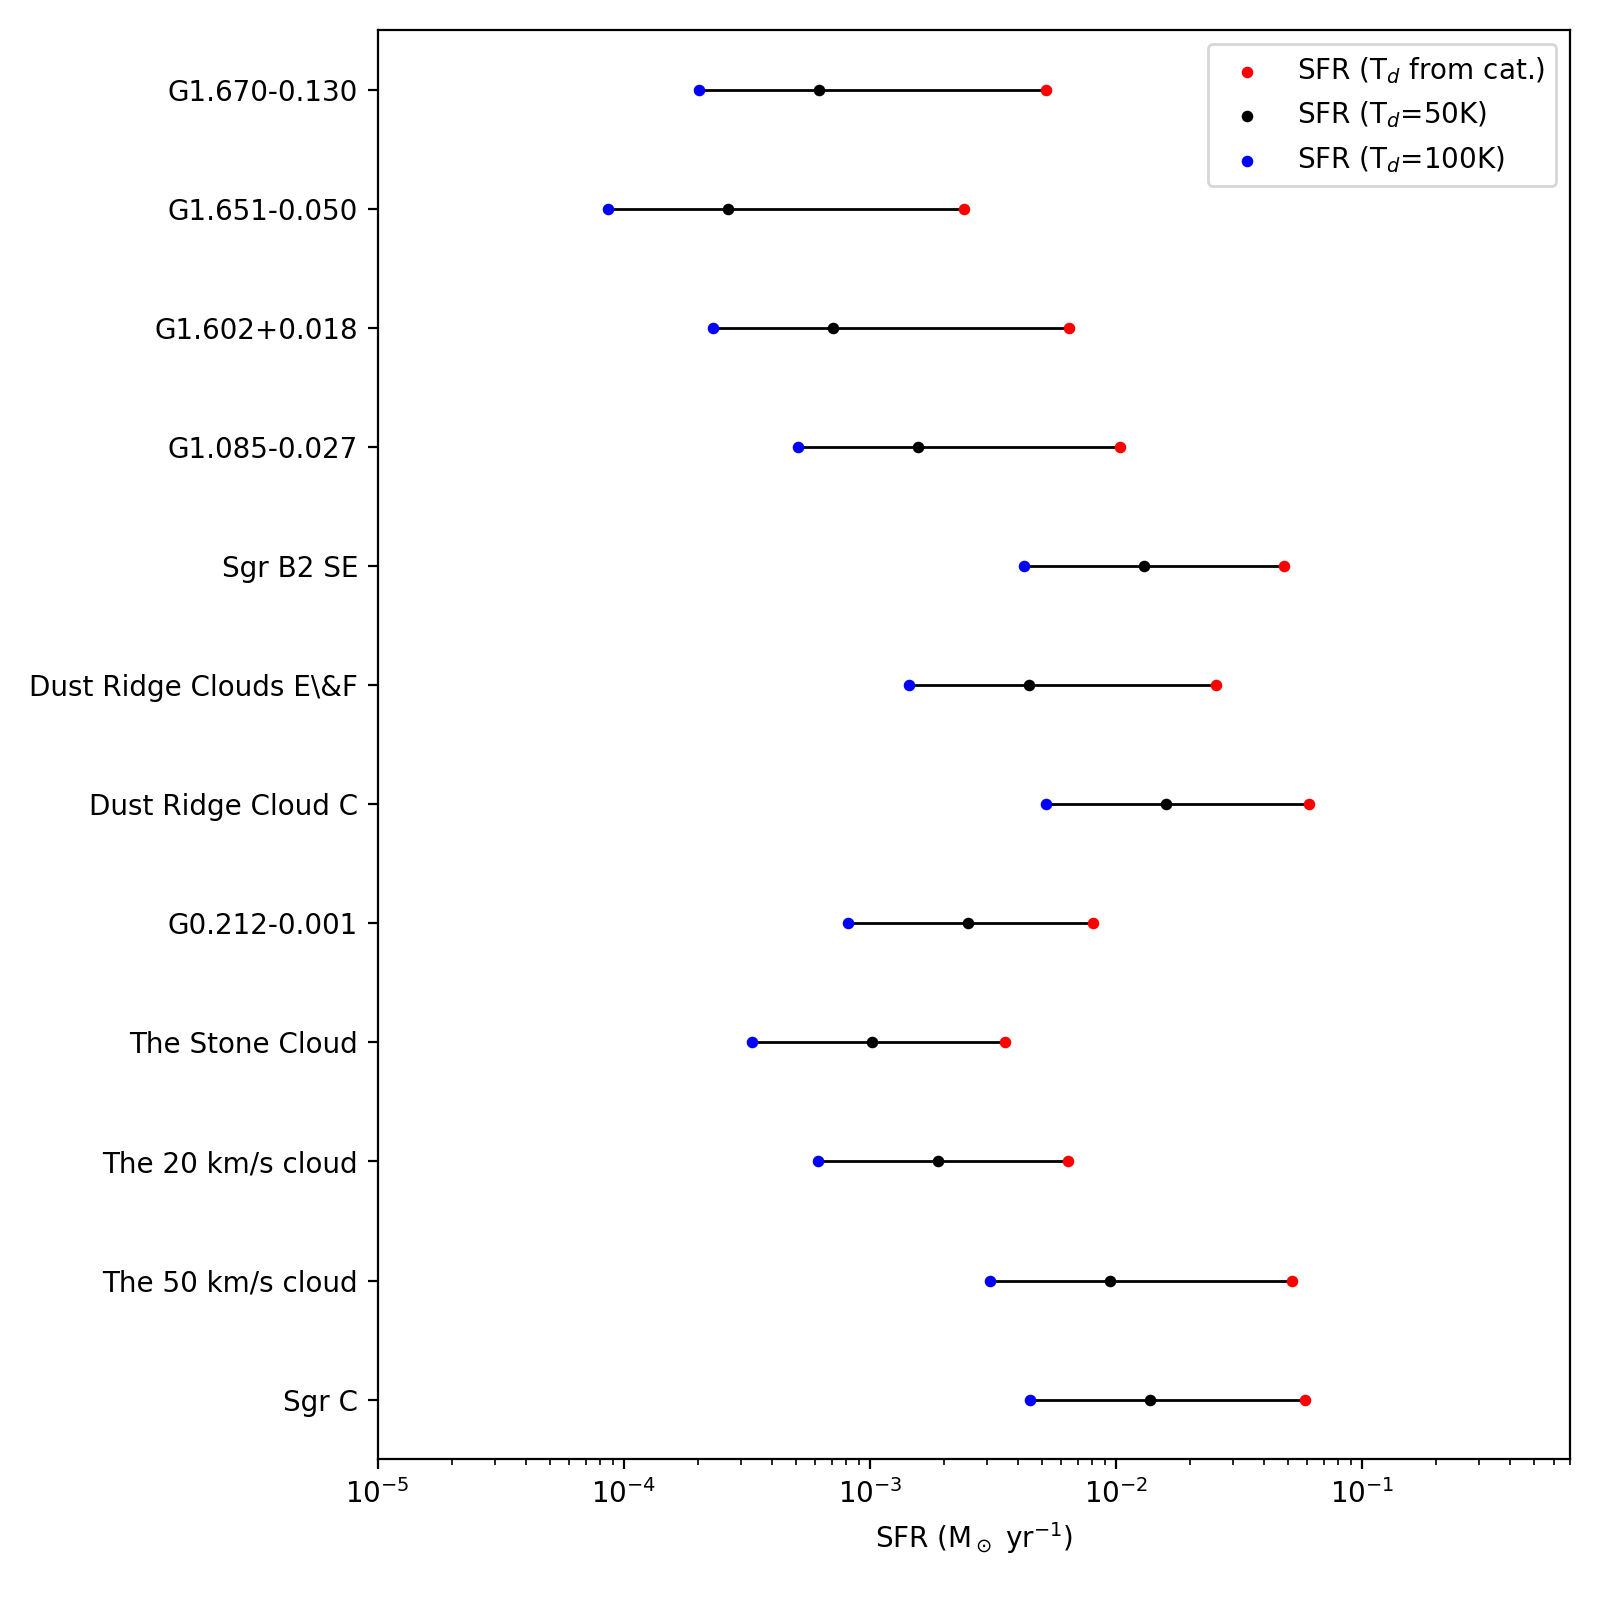

12


In [31]:
### cloud bound analysis, but with varying temperature FOR ROBUST SF (NOT including ambiguous) and implied sfr by IMF
### makes the assumption that detected sources are high mass component of IMF ONLY (low mass elsewhere undetected)

### calculate IMF extrapolation 
import imf
kroupa = imf.Kroupa()
mmax = 200
cutoff1 = 8
over8fraction = (kroupa.m_integrate(cutoff1, mmax)[0] /
                 kroupa.m_integrate(kroupa.mmin, mmax)[0])
#over8fraction = 1.

### calculate 50K, 100K masses, tffs
sfr_robust_Td_h = np.zeros(36)
sfr_robust_Td_m = np.zeros(36)
sfr_robust_Td_l = np.zeros(36)

sgrb2_sfr = 0.035
sgrb2_sfr_max = 0.062

sfe = 0.4
dsfe= 0.3
Td_l = 20
Td_m = 50
Td_h = 100

### calculate upper masses
mass_Td_l = teamcat['mass']
mass_Td_m = cmz.mass_calc_submm(cmz.Wave, Td_m, cmz.Kappa, teamcat['flux_integrated'], cmz.distance)
mass_Td_h = cmz.mass_calc_submm(cmz.Wave, Td_h, cmz.Kappa, teamcat['flux_integrated'], cmz.distance)

tff_Td_l = teamcat['tff']
tff_Td_m = cmz.tff_spherical_F(cmz.number_density_sphere_pc(mass_Td_m, catalog['r_eff'].data*cmz.arcsec2pc, cmz.mu), cmz.mu)
tff_Td_h = cmz.tff_spherical_F(cmz.number_density_sphere_pc(mass_Td_h, catalog['r_eff'].data*cmz.arcsec2pc, cmz.mu), cmz.mu)

for i in range(36):
    ccond = np.where(((teamcat['SF_final_say']==1))&(teamcat['mask_num']!=27) & 
                     (catalog['mask_num']==i+1) & (teamcat['mask_num']!=9) & 
                     (teamcat['mask_num']!=13) & (teamcat['mask_num']!=17) &
                     (teamcat['mask_num']!=33))[0]

    sfr_robust_Td_l[i] = sfe*np.sum(mass_Td_l[ccond]/tff_Td_l[ccond])/over8fraction
    sfr_robust_Td_m[i] = sfe*np.sum(mass_Td_m[ccond]/tff_Td_m[ccond])/over8fraction
    sfr_robust_Td_h[i] = sfe*np.sum(mass_Td_h[ccond]/tff_Td_h[ccond])/over8fraction

cmz_sfr_Td_h = 0.
cmz_sfr_Td_m = 0.
cmz_sfr_Td_l = 0.

for i in range(36):
    if (i+1!=9):
        cmz_sfr_Td_h+=sfr_robust_Td_h[i]
        cmz_sfr_Td_m+=sfr_robust_Td_m[i]
        cmz_sfr_Td_l+=sfr_robust_Td_l[i]

cmz_sfr_Td_l = cmz_sfr_Td_l + sgrb2_sfr
cmz_sfr_Td_m = cmz_sfr_Td_m + sgrb2_sfr
cmz_sfr_Td_h = cmz_sfr_Td_h + sgrb2_sfr

print(cmz_sfr_Td_h, cmz_sfr_Td_m, cmz_sfr_Td_l)

### plot sfr by cloud for verying temperature
sfr_cnames_nsgrb2 = ['G1.670-0.130', 'G1.651-0.050', 'G1.602+0.018', 'G1.085-0.027', 'Sgr B2 SE', 'Dust Ridge Clouds E&F', 'Dust Ridge Cloud C', 'G0.212-0.001',
 'The Stone Cloud', 'The 20 km/s cloud', 'The 50 km/s cloud', 'Sgr C']

sfrcond = np.where(sfr_robust_Td_h>0)[0]
sub_sfr_robust_lower = sfr_robust_Td_h[sfrcond]
sub_sfr_centers = sfr_robust_Td_m[sfrcond]
sub_sfr_robust_upper = sfr_robust_Td_l[sfrcond]

fig, ax = plt.subplots(figsize=(8,8))
ax.set_ylim(11.5,-0.5)
ax.set_xlim(0.00001,0.7)
# ax.errorbar(x=[0.035],y=[9], xlolims=True, xerr=0.062-0.035,color='green',capsize=4,
#            capthick=2.0,ls='',linewidth=1.0,label='Sgr B2 (G18)')
for i in range(len(sub_sfr_centers)):
    if i==len(sub_sfr_centers)-1:
        ax.scatter(y=i,x=sub_sfr_robust_upper[i], marker='o',color='r',s=10,label='SFR (T$_d$ from cat.)',zorder=1000)
        ax.scatter(y=i,x=sub_sfr_centers[i], marker='o',color='k',s=10,label='SFR (T$_d$=50K)',zorder=1000)
        ax.scatter(y=i,x=sub_sfr_robust_lower[i], marker='o',color='b',s=10,label='SFR (T$_d$=100K)',zorder=1000)

        ax.errorbar(y=i,x=sub_sfr_centers[i],xerr=([sub_sfr_centers[i]-sub_sfr_robust_lower[i]], [sub_sfr_robust_upper[i]-sub_sfr_centers[i]]),
                    linewidth=1,marker='',capsize=0,color='k')
    else:
        ax.scatter(y=i,x=sub_sfr_robust_upper[i], marker='o',color='r',s=10,zorder=1000)
        ax.scatter(y=i,x=sub_sfr_centers[i], marker='o',color='k',s=10,zorder=1000)
        ax.scatter(y=i,x=sub_sfr_robust_lower[i], marker='o',color='b',s=10,zorder=1000)

        ax.errorbar(y=i,x=sub_sfr_centers[i],xerr=([sub_sfr_centers[i]-sub_sfr_robust_lower[i]], [sub_sfr_robust_upper[i]-sub_sfr_centers[i]]),
                    linewidth=1,marker='',capsize=0,color='k')


cnames_amb = cnames[sfrcond]
cnames_amb[np.where(cnames_amb=='')[0]]=region_names[sfrcond[np.where(cnames_amb=='')[0]]]

ax.set_yticks(np.arange(0,len(sub_sfr_centers)))
ax.set_yticklabels(cnames_amb)
ax.set_xscale('log')
ax.set_xlabel('SFR (M$_\odot$ yr$^{-1}$)')
ax.legend(loc='upper right')
fig.tight_layout()
print(len(sub_sfr_centers))
fig.savefig('/Users/hph/Dropbox/astrophys/CMZoom/SF_tracer_paper/sfr_variation_Td_robust.pdf')


array([ 1,  2,  3,  4, 18, 21, 28, 29])

['' '' '' '' 'Sgr B2 SE' 'Dust Ridge Clouds E\\&F' 'Dust Ridge Cloud C' ''
 'The Stone Cloud' 'The 20 km/s cloud' 'The 50 km/s cloud' 'Sgr C']
[ 1  2  3  4  9 10 13 18 22 25 27 33]


In [53]:
print(cnames[sfrcond])
print(sfrcond)

['' '' '' '' 'Sgr B2 SE' 'Dust Ridge Clouds E\\&F' 'Dust Ridge Cloud C' ''
 'The Stone Cloud' 'The 20 km/s cloud' 'The 50 km/s cloud' 'Sgr C']
[ 1  2  3  4  9 10 13 18 22 25 27 33]


In [55]:
print(region_names[sfrcond])

['G1.670-0.130' 'G1.651-0.050' 'G1.602+0.018' 'G1.085-0.027'
 'G0.619+0.012' 'G0.489+0.010' 'G0.380+0.050' 'G0.212-0.001'
 'G0.068-0.075' 'G0.001-0.058' 'G359.889-0.093' 'G359.615-0.243']


In [98]:
print(region_names[16])
cnames[15]='The Sailfish'


G0.316-0.201


In [56]:
sfr_cnames = ['G1.670-0.130', 'G1.651-0.050', 'G1.602+0.018', 'G1.085-0.027', 'Sgr B2', 'Sgr B2 SE', 'Dust Ridge Clouds E\\&F', 'Dust Ridge Cloud C', 'G0.212-0.001',
 'The Stone Cloud', 'The 20 km/s cloud', 'The 50 km/s cloud', 'Sgr C']

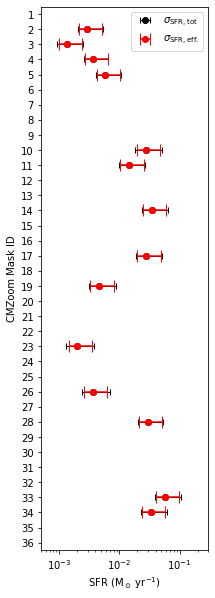

In [44]:
### plot sfr by cloud with errors (after adam's comments 3/22)
sfr_robust_nsgrb2 = np.copy(sfr_robust_bycloud)
dsfrp_robust_nsgrb2 = np.copy(dsfrp_robust_final)
dsfrm_robust_nsgrb2 = np.copy(dsfrm_robust_final)
dsfrp_eonly_robust_nsgrb2 = np.copy(dsfrp_robust_final_eonly)
dsfrm_eonly_robust_nsgrb2 = np.copy(dsfrm_robust_final_eonly)
sfr_robust_nsgrb2[8]=0
dsfrm_eonly_robust_nsgrb2[8]=0
dsfrm_robust_nsgrb2[8]=0
dsfrp_eonly_robust_nsgrb2[8]=0
dsfrp_robust_nsgrb2[8]=0
fig, ax = plt.subplots(figsize=(3,10))
ax.set_ylim(36.5,0.5)
ax.set_xlim(0.0005,0.3)
ax.errorbar(y=np.arange(1,37),x=sfr_robust_nsgrb2, xerr=(dsfrm_robust_nsgrb2,dsfrp_robust_nsgrb2),
            ls='',linewidth=1,marker='o',color='k',capsize=3,label='$\sigma_{\\rm SFR, tot}$')
ax.errorbar(y=np.arange(1,37),x=sfr_robust_nsgrb2, xerr=(dsfrm_eonly_robust_nsgrb2,dsfrp_eonly_robust_nsgrb2),
            ls='',linewidth=1.5,marker='o',color='r',capsize=6,zorder=100, label='$\sigma_{\\rm SFR, eff.}$')
ax.set_yticks(np.arange(1,37))
ax.set_xscale('log')
ax.set_xlabel('SFR (M$_\odot$ yr$^{-1}$)')
ax.set_ylabel('CMZoom Mask ID')
ax.legend(loc='upper right')

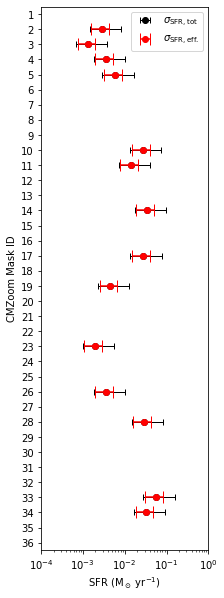

In [25]:
### plot sfr by cloud with errors
sfr_robust_nsgrb2 = np.copy(sfr_robust_bycloud)
sfr_robust_nsgrb2[8]=0
dsfrm_robust_nsgrb2 = np.copy(dsfrm_robust)
dsfr_robust_nsgrb2 = np.copy(dsfr_robust)
dsfr_eonly_robust_nsgrb2 = np.copy(dsfr_eonly_robust)
dsfrm_eonly_robust_nsgrb2 = np.copy(dsfrm_eonly_robust)
dsfrm_eonly_robust_nsgrb2[8]=0
dsfrm_robust_nsgrb2[8]=0
dsfr_eonly_robust_nsgrb2[8]=0
dsfr_robust_nsgrb2[8]=0
fig, ax = plt.subplots(figsize=(3,10))
ax.set_ylim(36.5,0.5)
ax.set_xlim(0.0001,1.0)
ax.errorbar(y=np.arange(1,37),x=sfr_robust_nsgrb2, xerr=(dsfrm_robust_nsgrb2,dsfr_robust_nsgrb2),
            ls='',linewidth=1,marker='o',color='k',capsize=3,label='$\sigma_{\\rm SFR, tot}$')
ax.errorbar(y=np.arange(1,37),x=sfr_robust_nsgrb2, xerr=dsfr_eonly_robust_nsgrb2,
            ls='',linewidth=1.5,marker='o',color='r',capsize=6,zorder=100, label='$\sigma_{\\rm SFR, eff.}$')
ax.set_yticks(np.arange(1,37))
ax.set_xscale('log')
ax.set_xlabel('SFR (M$_\odot$ yr$^{-1}$)')
ax.set_ylabel('CMZoom Mask ID')
ax.legend(loc='upper right')

#plt.savefig(savepath+'sfr_bounds.pdf',dpi=100,bbox_inches='tight')



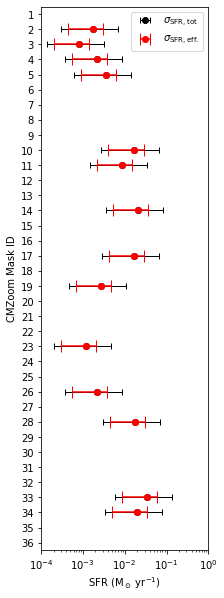

In [23]:
### plot sfr by cloud with errors
sfr_robust_nsgrb2 = np.copy(sfr_robust_bycloud)
sfr_robust_nsgrb2[8]=0
dsfrm_robust_nsgrb2 = np.copy(dsfrm_robust)
dsfrm_eonly_robust_nsgrb2 = np.copy(dsfrm_eonly_robust)
dsfrm_eonly_robust_nsgrb2[8]=0
dsfrm_robust_nsgrb2[8]=0
fig, ax = plt.subplots(figsize=(3,10))
ax.set_ylim(36.5,0.5)
ax.set_xlim(0.0001,1.0)
ax.errorbar(y=np.arange(1,37),x=sfr_robust_nsgrb2, xerr=(dsfrm_robust_nsgrb2,dsfr_robust_nsgrb2),
            ls='',linewidth=1,marker='o',color='k',capsize=3,label='$\sigma_{\\rm SFR, tot}$')
ax.errorbar(y=np.arange(1,37),x=sfr_robust_nsgrb2, xerr=dsfr_eonly_robust_nsgrb2,
            ls='',linewidth=1.5,marker='o',color='r',capsize=6,zorder=100, label='$\sigma_{\\rm SFR, eff.}$')
ax.set_yticks(np.arange(1,37))
ax.set_xscale('log')
ax.set_xlabel('SFR (M$_\odot$ yr$^{-1}$)')
ax.set_ylabel('CMZoom Mask ID')
ax.legend(loc='upper right')

In [123]:
sfr_robust_bycloud-dsfrm_robust

array([ 0.00000000e+00, -5.62120038e-05, -2.61086180e-05, -6.99491672e-05,
       -1.12449587e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.88853523e-01, -5.20967267e-04, -2.75436137e-04,  0.00000000e+00,
        0.00000000e+00, -6.59012741e-04,  0.00000000e+00,  0.00000000e+00,
       -5.27205339e-04,  0.00000000e+00, -8.75676950e-05,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -3.82072229e-05,  0.00000000e+00,
        0.00000000e+00, -6.90803806e-05,  0.00000000e+00, -5.60585532e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.07590756e-03, -6.35485988e-04,  0.00000000e+00,  0.00000000e+00])

In [124]:
sfr_robust_bycloud-dsfr_robust

array([ 0.00000000e+00, -3.41931704e-03, -1.58815977e-03, -4.25493424e-03,
       -6.84019003e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.36535506e+01, -3.16898907e-02, -1.67544904e-02,  0.00000000e+00,
        0.00000000e+00, -4.00870517e-02,  0.00000000e+00,  0.00000000e+00,
       -3.20693460e-02,  0.00000000e+00, -5.32665075e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.32410517e-03,  0.00000000e+00,
        0.00000000e+00, -4.20208687e-03,  0.00000000e+00, -3.40998281e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -6.54463249e-02, -3.86559440e-02,  0.00000000e+00,  0.00000000e+00])

In [136]:
print(np.unique(np.array(teamcat['mask_num'][teamcat['atoll_final_say']!=0])))

[ 8 10 14 16 17 19 20 22 26 28]


In [137]:
print(np.sort(np.array(teamcat['mask_num'][teamcat['atoll_final_say']!=0])))

[ 8  8  8  8  8  8  8  8  8  8  8  8 10 10 10 10 10 10 14 14 14 16 16 17
 17 17 19 19 19 20 22 22 26 26 26 26 26 28 28]


In [138]:
region_names[19]

'G0.145-0.086'

In [140]:
print(np.sort(np.array(teamcat['leaf_ID'][teamcat['atoll_final_say']!=0])))

[b'G0.001-0.058a' b'G0.001-0.058b' b'G0.001-0.058h' b'G0.001-0.058j'
 b'G0.001-0.058r' b'G0.070-0.035d' b'G0.070-0.035e' b'G0.145-0.086a'
 b'G0.212-0.001a' b'G0.212-0.001b' b'G0.212-0.001e' b'G0.316-0.201b'
 b'G0.316-0.201d' b'G0.316-0.201f' b'G0.326-0.085a' b'G0.326-0.085b'
 b'G0.380+0.050f' b'G0.380+0.050g' b'G0.380+0.050h' b'G0.619+0.012a'
 b'G0.619+0.012b' b'G0.619+0.012c' b'G0.619+0.012d' b'G0.619+0.012g'
 b'G0.619+0.012j' b'G0.714-0.100a' b'G0.714-0.100c' b'G0.714-0.100e'
 b'G0.714-0.100f' b'G0.714-0.100i' b'G0.714-0.100k' b'G0.714-0.100m'
 b'G0.714-0.100o' b'G0.714-0.100p' b'G0.714-0.100q' b'G0.714-0.100u'
 b'G0.714-0.100w' b'G359.889-0.093b' b'G359.889-0.093c']
